Model II: synthetic problem generator

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import matplotlib.pyplot as plt
from pymoo.core.problem import ElementwiseProblem
import matplotlib.pyplot as plt
from pymoo.core.repair import Repair


In [6]:
class HSEProblem_2(ElementwiseProblem):
    def __init__(self, 
                 data, 
                 candidate_data, 
                 d_ij,
                 d_ik,
                 p_candidates, 
                 coverage, 
                 d_thres,
                 predicted_feature_col, 
                 demand_col, 
                #  access_score_col,
                 initial_demand_probability,
                 **kwargs):
        
        self.evaluator = Evaluator()

        # Number of candidates and demands
        self.y_height = len(candidate_data)
        self.y_width = len(d_ij.drop('region', axis=1).columns)
        self.hse_width = len(d_ik.drop('region', axis=1).columns)

        # Number of decision variables for candidates and coverage matrix
        self.n_var_x = len(candidate_data)
        self.n_var_y = self.y_height * self.y_width
        self.coverage = coverage

        # Total number of decision variables (flattened coverage matrix)
        self.n = self.n_var_x

        # Column names
        self.predicted_feature_col = predicted_feature_col
        self.demand_col = demand_col
        # self.access_score_col = access_score_col

        # Initialise the problem with number of variables, objectives, and constraints
        super().__init__(n_var=self.n,
                         n_obj=3,
                         n_ieq_constr=self.n_var_y + int((self.n_var_x * (self.n_var_x - 1))/2) + (self.n_var_x * self.hse_width),
                         n_eq_constr=1 + self.y_width,
                         xl=0,
                         xu=1,
                         **kwargs)

        # Decision variable bounds: 0 to 1
        self.xl = np.zeros(self.n)
        self.xu = np.ones(self.n)

        # Store the provided data for evaluation
        self.data = data
        self.d_ii = candidate_data
        self.d_ij = d_ij
        self.d_ik = d_ik
        self.p_candidates = p_candidates
        self.d_thres = d_thres

        # Stochasticity
        self.demand_probability = initial_demand_probability  # This will be updated dynamically
        self.current_generation = 0
        self.old_gen = 0
        
    def set_probability(self, prob):
        self.demand_probability = prob  # Set the current generation


    def _evaluate(self, x, out, *args, **kwargs):
        # Import data sets for evaluation
        op_data = self.data
        d_ii = self.d_ii
        d_ij = self.d_ij
        d_ik = self.d_ik

        # Extract relevant data from the input data sets
        mpr = np.array(op_data[self.predicted_feature_col])     # MPR data
        demand_i = np.array(op_data[self.demand_col])           # Demand data

        d_ii = d_ii.drop('region', axis=1).values               # Candidate matrix
        d_ij = d_ij.drop('region', axis=1).values               # Demand matrix
        d_ik = d_ik.drop('region', axis=1).values               # HSE matrix
        d_thres = self.d_thres                                  # Max Distance threshold
        R = 5000                                                # Min Distance threshold
        M = max([d_ii.max().max(),
                 d_ij.max().max(),
                 d_ik.max().max()
                ]) + 5000                                       # Big M

        # Extract decision variables
        xi = x[:self.n_var_x] # Candidate variables
        # xi = np.array([1, 0, 1, 1, 0, 1])
        y_vars = np.zeros((self.y_height, self.y_width), dtype=int)

        d_ij_values = d_ij * np.where(xi == 0, 1000000, xi)[:, np.newaxis]

        # Iterate through each demand (width)
        for j in range(self.y_width):  # Iterate over demands
            # Find the nearest candidate (min distance)
            nearest_candidate = np.argmin(d_ij_values[:, j])
            
            # Assign the nearest candidate (1 for the nearest, 0 for others)
            y_vars[:, j] = 0  # Set all to 0 first
            y_vars[nearest_candidate, j] = 1  # Set the nearest to 1

        y_within = (d_ij_values <= d_thres)*1
        yij = y_vars
        yij_within = y_vars * y_within

        # ui = demand_i *  pi * self.demand_probability 
        ui = demand_i * self.demand_probability 

        # Define objective functions
        # Objective 1: Minimise demand weighted distance
        f1 = np.sum(ui * np.sum(d_ij * yij_within, axis=1))

        # Objective 2: Maximise stochastic demand
        f2 = -1 * np.sum(ui * np.sum(yij_within, axis = 1))
        
        # Objective 3: Maximise MPR
        f3 = -1 * np.sum(mpr * xi)

        # Inequality constraint  2: Coverage matrix should be consistent with the candidate locations
        iec2 = np.zeros((self.y_height * self.y_width))
        idx = 0
        for i in range(self.y_height):
            for j in range(self.y_width):
                iec2[idx] = int(yij[i][j]) - int(xi[i])
                idx += 1

        # Define the constraint
        iec3 = []
        for i in range(len(xi)):
            for j in range(i + 1, len(xi)):
                if i != j:
                    # Apply the constraint: d_ii * (x_i + x_j - 1) >= R
                    cons = R - d_ii[i, j] - M*(1 - xi[i]) - M*(1 - xi[j])
                    iec3.append(cons)

        iec4 = []
        for i in range(len(xi)):
            for k in range(self.hse_width):
                cons = R - d_ik[i, k] - M*(1 - x[i])
                iec4.append(cons)

        iec_list = iec2.tolist() + iec3 + iec4

        ec1 = 1 - np.sum(yij, axis=0)
        ec1_list = ec1.flatten().tolist()
        ec2 = np.sum(xi) - self.p_candidates

        f = [f1, f2, f3]
        g = iec_list
        h =  ec1_list + [ec2]

        # assert 1 == 2
        out["F"] = f
        out["G"] = g
        out["H"] = h

### Repair functions ###
class ClipRepair(Repair):

    def __init__(self, xl, xu):
        super().__init__()
        self.xl = xl
        self.xu = xu

    def _do(self, problem, pop, **kwargs):
        return np.clip(pop, self.xl, self.xu).astype(int)

# Combination of repairs
class CustomRepair(Repair):
    def __init__(self, xl, xu, width, height):
        super().__init__()
        self.clip_repair = ClipRepair(xl, xu)

    def _do(self, problem, pop, **kwargs):
        pop = self.clip_repair._do(problem, pop, **kwargs)
        return pop
    
def generation_callback(algorithm):
    gen = algorithm.n_gen  # Access the current generation from the algorithm
    # Save the current state
    current_state = random.getstate()
    random.seed(gen)
    random_number = 0.5# random.uniform(0.1, 0.7)
    random.setstate(current_state)
    algorithm.problem.set_probability(random_number)  # Pass the generation to the problem


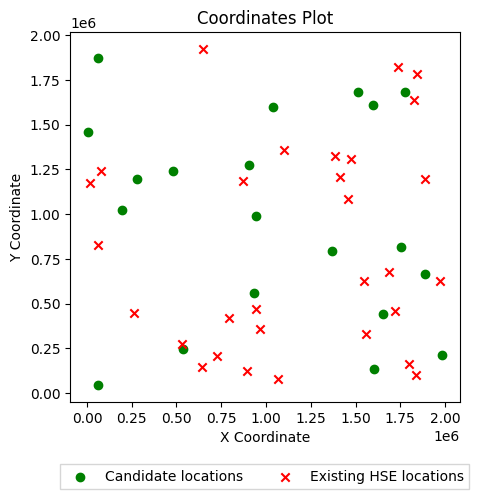

In [8]:
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to generate coordinates for candidates, demands, and HSEs
def generate_coordinates(num_candidates, num_demands, num_hses, distance, seed):
    # Set random seed for reproducibility
    random.seed(seed)

    # Function to generate points around candidate locations
    def generate_set_near_candidates(candidates, num_points_range=(2,4), min_distance=500, max_distance=20000):
        all_points = []  # List to store generated points

        # For each candidate, generate a number of points around it
        for candidate in candidates:
            num_points = random.randint(num_points_range[0], num_points_range[1])
            candidate_points = []  # Points generated near the current candidate

            # Generate points until the desired number of points is reached
            while len(candidate_points) < num_points:
                # Random angle and distance from the candidate point
                angle = random.uniform(0, 2 * math.pi)
                distance = random.uniform(min_distance, max_distance)
                # Calculate x and y coordinates for the new point
                x = candidate[0] + distance * math.cos(angle)
                y = candidate[1] + distance * math.sin(angle)
                candidate_points.append((x, y))

            # Add the generated points to the list
            all_points.extend(candidate_points)

        return all_points

    # Function to calculate Euclidean distance between two points
    def euclidean_distance(p1, p2):
        return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

    # Function to generate candidate locations ensuring minimum distance between them
    def generate_set_candidates(num_candidates, distance, min_distance):
        points = []  # List to store candidate points

        # Generate candidate points
        while len(points) < num_candidates:
            x = random.randint(0, distance)  # Random x-coordinate
            y = random.randint(0, distance)  # Random y-coordinate

            # Ensure minimum distance between generated point and existing points
            valid = all(euclidean_distance((x, y), p) >= min_distance for p in points)

            # If valid, add the point to the list
            if valid:
                points.append((x, y))

        return points

    # Generate candidate, demand, and HSE points
    candidates = generate_set_candidates(num_candidates, distance, min_distance=5000)
    demands = generate_set_near_candidates(candidates, num_points_range=(num_demands, num_demands))
    hses = generate_set_candidates(num_hses, distance, min_distance=5000)

    # Generate random market shares and demand values for candidates
    market_shares = [random.uniform(0.1, 6) for i in range(num_candidates)]  # Market share (0.1 to 6%)
    demand = [random.randint(140000, 600000) for i in range(num_candidates)]  # Demand range (140,000 to 600,000)

    # Create a DataFrame to hold region, market share, and demand data
    data = {
        'region': ['region_{}'.format(i + 1) for i in range(num_candidates)],
        'market_share': market_shares,
        'demand': demand,
    }

    df = pd.DataFrame(data)

    return candidates, demands, hses, df

# Function to calculate Euclidean distance matrix between points (e.g., candidates and demands)
def euclidean_distance_matrix(candidates, demands):
    candidates = np.array(candidates)
    demands = np.array(demands)
    num_candidates = candidates.shape[0]
    num_demands = demands.shape[0]
    distances = np.zeros((num_demands, num_candidates))  # Initialize distance matrix

    # Calculate distances between each demand and each candidate
    for i in range(num_demands):
        distances[i] = np.round(np.linalg.norm(candidates - demands[i], axis=1), 0)

    return distances

# Function to plot candidate, demand, and HSE points
def plot_problem(candidates, demands, hses, solution='None'):
    plt.figure()

    # Unpack candidate, demand, and HSE coordinates for plotting
    candidates_x, candidates_y = zip(*candidates)
    demands_x, demands_y = zip(*demands)
    hses_x, hses_y = zip(*hses)

    # Plot candidate points, separating placed and left candidates if solution is provided
    if solution == "None":
        plt.scatter(candidates_x, candidates_y, color='#008000', marker='o', label='Candidate locations')
    else:
        x_place = np.round(candidates_x, 0)[solution == 1]
        y_place = np.round(candidates_y, 0)[solution == 1]
        x_leave = np.round(candidates_x, 0)[solution == 0]
        y_leave = np.round(candidates_y, 0)[solution == 0]

        plt.scatter(x_place, y_place, color='#008000', marker='o', label=f'{len(x_place)} Candidates placed')
        plt.scatter(x_leave, y_leave, color='black', marker='o', label=f'{len(x_leave)} Candidates left')

    # Plot HSE points
    plt.scatter(hses_x, hses_y, color='red', marker='x', label='Existing HSE locations')

    # Set plot labels and title
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Coordinates Plot')

    # Add a legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=False, shadow=False, ncol=3)

    plt.axis('equal')
    plt.gca().set_aspect('equal', adjustable='box')

    return plt

# Function to convert list data to DataFrame and add region information
def convert_to_df(relevant_list):
    df = pd.DataFrame(relevant_list)

    # Add 'region' column for region names
    n_regions = df.shape[0]
    df['region'] = ['region_{}'.format(i + 1) for i in range(n_regions)]

    return df

# Problem generation parameters
number = 1
candidates_list = [6, 20, 40, 60]  # Number of candidates locations
demands_list = [2, 3, 3, 3]        # Number of demand locations per candidate location
distance_list = [1000000, 2000000, 2000000, 2000000]  # Size of the region or v in Model II
p_max = [3, 10, 20, 30]  # Number of facilities that should be established
seed_list = [1, 2, 3, 4]  # Random seeds for reproducibility or s_2

# Select parameters based on the current problem (index = number)
num_candidates = candidates_list[number]
num_demands = demands_list[number] 
num_hses = 30  # Number of existing HSEs
distance = distance_list[number]
seed = 1  # Random seed or s_2

# Generate candidates, demands, HSEs, and dataset
candidates, demands, hses, moo_dataset = generate_coordinates(num_candidates,
                                                              num_demands,
                                                              num_hses,
                                                              distance,
                                                              seed)

# Plot the generated problem
plt = plot_problem(candidates, demands, hses)

# Calculate distance matrices for candidates, demands, and HSEs
candidate_data = euclidean_distance_matrix(candidates, candidates)
demand_data = euclidean_distance_matrix(demands, candidates)
hse_data = euclidean_distance_matrix(hses, candidates)

# Convert distance matrices to DataFrames and add region information
candidate_data = convert_to_df(candidate_data)
demand_data = convert_to_df(demand_data)
hse_data = convert_to_df(hse_data)
